In [ ]:
import pandas as pd

: 

## Load Data

In [ ]:
df = pd.read_csv('data/reliance/trials_data.csv')

df

In [ ]:
# 1. Drop any trial within a session where initial, AI, or final alloc was 50/50
mask_invalid = df.groupby(['session_id','new_trial_num'])['fund_a'] \
                 .transform(lambda x: x.eq(50).any())
df_valid = df[~mask_invalid].copy()

df_valid 

In [ ]:






# 2. Compute RAIR & RSR per session
session_results = []

for session_id, grp in df_valid.groupby('session_id'):
    scenario = grp['scenario_name'].iat[0]
    
    # pivot to get allocations & returns by allocation_type
    pt_a = grp.pivot_table(index='new_trial_num', columns='allocation_type',
                           values='fund_a', aggfunc='first') \
             .reindex(columns=['initial','ai','final'])
    pt_b = grp.pivot_table(index='new_trial_num', columns='allocation_type',
                           values='fund_b', aggfunc='first') \
             .reindex(columns=['initial','ai','final'])
    r_a  = grp.pivot_table(index='new_trial_num', columns='allocation_type',
                           values='actual_return_a', aggfunc='first') \
             .reindex(columns=['initial','ai','final'])
    r_b  = grp.pivot_table(index='new_trial_num', columns='allocation_type',
                           values='actual_return_b', aggfunc='first') \
             .reindex(columns=['initial','ai','final'])
    
    # keep only complete trials
    complete = pt_a.notna().all(1) & pt_b.notna().all(1) & \
               r_a.notna().all(1) & r_b.notna().all(1)
    pt_a, pt_b, r_a, r_b = pt_a[complete], pt_b[complete], r_a[complete], r_b[complete]
    
    # compute directions
    p = (r_b['initial'] > r_a['initial']).astype(int)
    i = (pt_b['initial'] > pt_a['initial']).astype(int)
    a = (pt_b['ai']      > pt_a['ai']).astype(int)
    f = (pt_b['final']   > pt_a['final']).astype(int)
    
    # classify
    ai_corr = a == p
    follow  = f == a
    stick   = f == i
    
    # metrics
    CA   = ai_corr.sum()
    IA   = (~ai_corr).sum()
    CAIR = (ai_corr & follow).sum()
    CSR  = ((~ai_corr) & stick).sum()
    RAIR = CAIR/CA if CA>0 else float('nan')
    RSR  = CSR/IA if IA>0 else float('nan')
    
    session_results.append({
        'session_id': session_id,
        'scenario_name': scenario,
        'RAIR': RAIR,
        'RSR': RSR
    })

per_session = pd.DataFrame(session_results)

# 3. Compute mean RAIR & RSR per scenario
scenario_means = per_session.groupby('scenario_name')[['RAIR','RSR']].mean().reset_index()

# # Display both tables
# from ace_tools import display_dataframe_to_user
# display_dataframe_to_user("Per‐Session RAIR & RSR", per_session)
# display_dataframe_to_user("Mean RAIR & RSR by Scenario", scenario_means)





In [ ]:
per_session

In [ ]:
 # Count non-missing RAIR and RSR per scenario
counts = per_session.groupby('scenario_name').agg(
    RAIR_count=('RAIR', 'count'),
    RSR_count=('RSR', 'count')
).reset_index()

print(counts)


In [ ]:
scenario_means

## Plot the results

In [ ]:
import matplotlib.pyplot as plt

In [ ]:


# Choose one distinct color per scenario
scenarios = per_session['scenario_name'].unique()
colors = plt.cm.tab10.colors  # up to 10 distinct colors
color_map = {sc: colors[i % len(colors)] for i, sc in enumerate(scenarios)}

fig, ax = plt.subplots()

# Plot session points
for sc, group in per_session.groupby('scenario_name'):
    ax.scatter(
        group['RAIR'], group['RSR'],
        color=color_map[sc],
        alpha=0.6,
        label=f"{sc} sessions"
    )

# Overlay the mean for each scenario
for _, row in scenario_means.iterrows():
    sc = row['scenario_name']
    ax.scatter(
        row['RAIR'], row['RSR'],
        marker='D', s=100,
        color=color_map[sc],
        edgecolor='k',
        label=f"{sc} mean"
    )

# Add dotted reference lines at 0.5
ax.axhline(0.5, linestyle='--', color='gray', linewidth=1)
ax.axvline(0.5, linestyle='--', color='gray', linewidth=1)

ax.set_xlabel('Relative AI Reliance (RAIR)')
ax.set_ylabel('Relative Self-Reliance (RSR)')
ax.set_title('Session-level RAIR vs RSR with Scenario Means')

# Clean up legend: avoid duplicate labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize='small', ncol=2)

plt.tight_layout()
plt.show()


## Kruskal-Wallis Test

In [ ]:
import pandas as pd
from scipy.stats import kruskal

# 1. Load or reference your per-session DataFrame
# per_session = pd.read_csv('/mnt/data/per_session.csv')

# Ensure it has columns: session_id, scenario_name, RAIR, RSR

# 2. Prepare RAIR groups
rair_data = [
    grp['RAIR'].dropna().values
    for _, grp in per_session.groupby('scenario_name')
]

# 3. Kruskal-Wallis test for RAIR
H_rair, p_rair = kruskal(*rair_data)
print(f"Kruskal-Wallis for RAIR: H = {H_rair:.3f}, p = {p_rair:.3f}")

# 4. Prepare RSR groups
rsr_data = [
    grp['RSR'].dropna().values
    for _, grp in per_session.groupby('scenario_name')
]

# 5. Kruskal-Wallis test for RSR
H_rsr, p_rsr = kruskal(*rsr_data)
print(f"Kruskal-Wallis for RSR: H = {H_rsr:.3f}, p = {p_rsr:.3f}")


In [ ]:
import pandas as pd
from scipy.stats import kruskal, rankdata

# Assuming per_session DataFrame is in memory with columns: ['session_id', 'scenario_name', 'RAIR', 'RSR']

def kruskal_stats(df, metric):
    # Drop NaNs
    d = df.dropna(subset=[metric]).copy()
    
    # Group values by scenario
    groups = [grp[metric].values for _, grp in d.groupby('scenario_name')]
    
    # Kruskal-Wallis test
    H, p = kruskal(*groups)
    
    # Gesamtzahl der Fälle
    N = len(d)
    # Erwartungswert der Rangplätze
    E_rank = (N + 1) / 2
    
    # Ränge berechnen
    d['rank'] = rankdata(d[metric])
    
    # Rangsummen pro Gruppe
    grp_stats = (
        d.groupby('scenario_name')
         .agg(n=('rank','size'),
              R_sum=('rank','sum'),
              mean_rank=('rank','mean'))
         .reset_index()
    )
    # Mittlere Rangsummen über alle Gruppen
    mean_R_sum = grp_stats['R_sum'].mean()
    
    # Freiheitsgrade
    k = grp_stats.shape[0]
    dfree = k - 1
    
    # Varianz der Rangplätze
    var_ranks = (N**2 - 1) / 12
    
    # Ausgabe
    print(f"### Kruskal-Wallis für {metric} ###")
    print(f"H = {H:.3f}, p = {p:.3f}")
    print(f"Anzahl der Fälle (N) = {N}")
    print(f"Erwartungswert der Rangplätze = {E_rank:.3f}")
    print(f"Mittlere Rangsummen (Ø R_sum) = {mean_R_sum:.3f}")
    print(f"Freiheitsgrade = {dfree}")
    print(f"Varianz der Rangplätze = {var_ranks:.3f}\n")
    print("Gruppenstatistiken:")
    display(grp_stats)

# Run for RAIR
kruskal_stats(per_session, 'RAIR')

# Run for RSR
kruskal_stats(per_session, 'RSR')

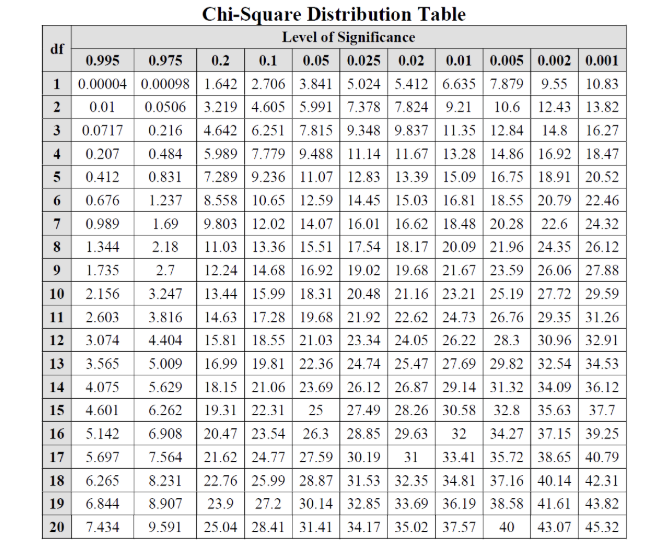

In [ ]:

# Filter to only sessions with both RAIR & RSR
ps = per_session.dropna(subset=['RAIR', 'RSR'])

ps

In [ ]:
# 3. Compute mean RAIR & RSR per scenario
sm = ps.groupby('scenario_name')[['RAIR','RSR']].mean().reset_index()
sm

In [ ]:


# Choose one distinct color per scenario
scenarios = ps['scenario_name'].unique()
colors = plt.cm.tab10.colors  # up to 10 distinct colors
color_map = {sc: colors[i % len(colors)] for i, sc in enumerate(scenarios)}

fig, ax = plt.subplots()

# Plot session points
for sc, group in ps.groupby('scenario_name'):
    ax.scatter(
        group['RAIR'], group['RSR'],
        color=color_map[sc],
        alpha=0.6,
        label=f"{sc} sessions"
    )

# Overlay the mean for each scenario
for _, row in sm.iterrows():
    sc = row['scenario_name']
    ax.scatter(
        row['RAIR'], row['RSR'],
        marker='D', s=100,
        color=color_map[sc],
        edgecolor='k',
        label=f"{sc} mean"
    )

# Add dotted reference lines at 0.5
ax.axhline(0.5, linestyle='--', color='gray', linewidth=1)
ax.axvline(0.5, linestyle='--', color='gray', linewidth=1)

ax.set_xlabel('Relative AI Reliance (RAIR)')
ax.set_ylabel('Relative Self-Reliance (RSR)')
ax.set_title('Session-level RAIR vs RSR with Scenario Means')

# Clean up legend: avoid duplicate labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize='small', ncol=2)

plt.tight_layout()
plt.show()


## Kruskal-Wallis Test

In [ ]:
import pandas as pd
from scipy.stats import kruskal

# 1. Load or reference your per-session DataFrame
# per_session = pd.read_csv('/mnt/data/per_session.csv')

# Ensure it has columns: session_id, scenario_name, RAIR, RSR

# 2. Prepare RAIR groups
rair_data = [
    grp['RAIR'].dropna().values
    for _, grp in per_session.groupby('scenario_name')
]

# 3. Kruskal-Wallis test for RAIR
H_rair, p_rair = kruskal(*rair_data)
print(f"Kruskal-Wallis for RAIR: H = {H_rair:.3f}, p = {p_rair:.3f}")

# 4. Prepare RSR groups
rsr_data = [
    grp['RSR'].dropna().values
    for _, grp in per_session.groupby('scenario_name')
]

# 5. Kruskal-Wallis test for RSR
H_rsr, p_rsr = kruskal(*rsr_data)
print(f"Kruskal-Wallis for RSR: H = {H_rsr:.3f}, p = {p_rsr:.3f}")
